In [ ]:
# Import all necessary classes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import random
import numpy as np
from sklearn.metrics import confusion_matrix
from upsetplot import from_contents, plot 
from torch.optim import lr_scheduler
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter 
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2
# Important local code (using autoreload to pick up local changes)
from mammogram_dataset import MammogramDataset
from utils import train_model, evaluate_model, show_confusion_matrix, print_single_view_results_table, compare_performance_all_views
from single_view_mammogram import SingleViewMammogram
from single_view_cnn import SingleViewCNN
from late_fusion_fc import LateFusionFC
from multi_view import MultiViewDataset
from resnet_feature_extractor import ResNetFeatureExtractor
from classifier_head import ClassifierHead
from noise_dataset import RandomNoiseDataset
from late_fusion_lr import LateFusionLR
from grayscale_dataset import GrayscaleToResnet50Dataset
from weight_late_fusion_fc import WeightedSumFusionModel
from attention_fusion import AttentionFusion
from moe import MoEViewFusion



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Configuration and Hyperparameters
CONFIG = {
    'num_classes': 1,  # Number of output classes for the dataset
    'num_views': 2,     # Number of views per sample (e.g., CC, MLO)
    'batch_size': 32,
    'mv_batch_size': 16,
    'learning_rate': 0.001,
    'num_epochs':  20,
    'mv_num_epochs':  30,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "patience": 10, # for early stopping
    "test_name": "baseline",
    "class_weight_type":None, # None,default , inv_norm or sqrt_inv_norm
    "seed": 5, #5, #11,27,42
    'lr_decay': False,
    "augment": False,
    "denoise": False,
}

In [134]:
save_dir = CONFIG["test_name"] + "_" + str(CONFIG["seed"])
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/config/workspace/final/multi_view_fusion/mammogram_research/BCE
Training dataset: In collect_files
Final dataset contains 690 unique mammogram ROI collection entities (each with both CC and MLO views, and matching CSV criteria if provided).
Test data dataset: In collect_files
Final dataset contains 137 unique mammogram ROI collection entities (each with both CC and MLO views, and matching CSV criteria if provided).
--- Mammogram ROI views Entity 1 ---
  Patient ID: P_01864  Breast Side: RIGHT  Abnormality ID:    1  Breast Density: 2 Pathology: BENIGN_WITHOUT_CALLBACK
View: CC_1:   Image Array Shape: (249, 265)
View: MLO_1:   Image Array Shape: (161, 185)


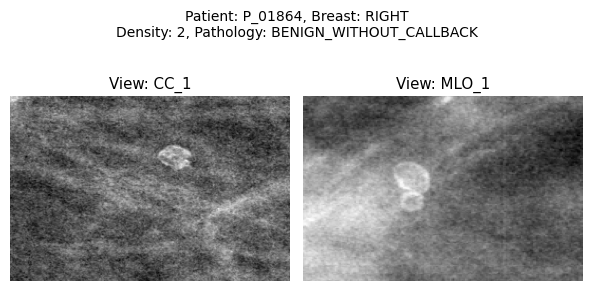

--- Mammogram ROI views Entity 2 ---
  Patient ID: P_00510  Breast Side: RIGHT  Abnormality ID:    2  Breast Density: 2 Pathology: BENIGN_WITHOUT_CALLBACK
View: MLO_2:   Image Array Shape: (169, 209)
View: CC_2:   Image Array Shape: (193, 217)


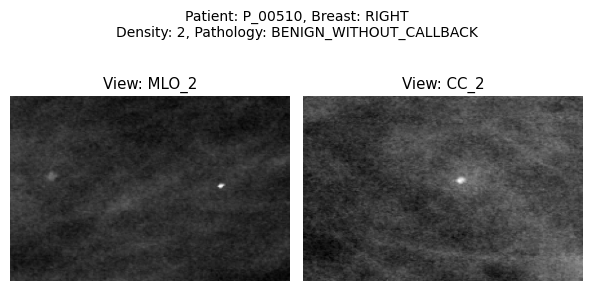

For the training data, there are 450 BENIGN and 240 MALIGNANT pathologies.
For the test data, there are 85 BENIGN and 52 MALIGNANT pathologies.


In [ ]:
# Initialize the dataset with the path to the CBIS-DDSM directory
# and the path to CSV files.
print(os.getcwd())
dataset_root = "../data/CBIS-DDSM TCIA/manifest-ZkhPvrLo5216730872708713142/"
# This test uses the calcifications from the CBIS-DDSM source
csv_path_for_train_dataset = '../data/CBIS-DDSM TCIA/calc_case_description_train_set.csv'
csv_path_for_test_dataset = '../data/CBIS-DDSM TCIA/calc_case_description_test_set.csv'

# Get the data we need from the csv and files 
print("Training dataset: ",end='')
mammogram_calc_train_dataset = MammogramDataset(dataset_root, csv_path=csv_path_for_train_dataset)
print("Test data dataset: ",end='')
mammogram_calc_test_dataset = MammogramDataset(dataset_root, csv_path=csv_path_for_test_dataset)

# Display an example of our data
for i in [0,1]:
    roi_data = mammogram_calc_train_dataset[i]
    print(f"--- Mammogram ROI views Entity {i+1} ---")
    print(f"  Patient ID: {roi_data['patient_id']}  Breast Side: {roi_data['breast_side']}  Abnormality ID:    {roi_data['abnormality id']}  Breast Density: {roi_data['breast density']} Pathology: {roi_data['pathology']}")  
    for j, image_info in enumerate(roi_data['images']):
        if image_info['file_path'].endswith("1-1.dcm"):
            print(f"View: {image_info['image_view']}:   Image Array Shape: {image_info['image'].shape}")

    mammogram_calc_train_dataset.display_roi_images(roi_data)

count_benign = 0
for entity in mammogram_calc_train_dataset.roi_entities:
    if "BENIGN" in (entity['pathology']).upper():  
        count_benign += 1
count_malignant = len(mammogram_calc_train_dataset) - count_benign
print(f"For the training data, there are {count_benign} BENIGN and {count_malignant} MALIGNANT pathologies.")
test_count_benign = 0
for entity in mammogram_calc_test_dataset.roi_entities:
    if "BENIGN" in (entity['pathology']).upper():  
        test_count_benign += 1
test_count_malignant = len(mammogram_calc_test_dataset) - test_count_benign
print(f"For the test data, there are {test_count_benign} BENIGN and {test_count_malignant} MALIGNANT pathologies.")

In [136]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset 
# Code to run Single Views
# Create a SingleView for CC images , training the Resnet50 CNN on the training data and then testing with the test set
print("SingleView for CC images")
single_view_cc = SingleViewMammogram(train_dataset=mammogram_calc_train_dataset, 
    test_dataset=mammogram_calc_test_dataset,view_type="CC")

# Create a SingleView for MLO images , training the Resnet50 CNN on the training data and then testing with the test set
print("SingleView for MLO images")
single_view_mlo = SingleViewMammogram(train_dataset=mammogram_calc_train_dataset, 
    test_dataset=mammogram_calc_test_dataset,view_type="MLO")

cc_train_and_val_dataset = GrayscaleToResnet50Dataset(single_view_cc.dataset_train_view, single_view_cc.dataset_train_pathology_binary_labels)
single_view_cc.set_test_view(GrayscaleToResnet50Dataset(single_view_cc.dataset_test_view, single_view_cc.dataset_test_pathology_binary_labels))

mlo_train_and_val_dataset = GrayscaleToResnet50Dataset(single_view_mlo.dataset_train_view, single_view_mlo.dataset_train_pathology_binary_labels)
single_view_mlo.set_test_view(GrayscaleToResnet50Dataset(single_view_mlo.dataset_test_view, single_view_mlo.dataset_test_pathology_binary_labels))

all_indices = np.arange(len(cc_train_and_val_dataset))
labels_for_stratification = np.array(cc_train_and_val_dataset.labels) # Convert labels to NumPy for sklearn

train_indices, val_indices, _, _ = train_test_split(
    all_indices, # We split the indices, not the data directly
    labels_for_stratification, # Stratify using the labels
    test_size=(15/85),
    random_state=CONFIG['seed'], # For reproducibility
    stratify=labels_for_stratification
)
train_datasetcc = Subset(cc_train_and_val_dataset, train_indices)
val_datasetcc = Subset(cc_train_and_val_dataset, val_indices)

train_datasetmlo = Subset(mlo_train_and_val_dataset, train_indices)
val_datasetmlo = Subset(mlo_train_and_val_dataset, val_indices)

single_view_cc.set_train_val_datasets(train_datasetcc,val_datasetcc)
single_view_mlo.set_train_val_datasets(train_datasetmlo,val_datasetmlo)


SingleView for CC images
SingleView for MLO images


Inverse freqs:  tensor([1.5351, 2.8687])

Train DataLoader has 18 batches. Dataset size: 568
Validation DataLoader has 4 batches. Dataset size: 122
Test DataLoader has 5 batches. Dataset size: 137
Frozen all parameters except the final layer.
Modified ResNet50 final layer: Linear(in_features=2048, out_features=1, bias=True)

Starting training with validation and early stopping...
Epoch 1/20
----------
train Loss: 0.6401 Acc: 0.6496
val Loss: 0.6429 Acc: 0.6721
Validation loss improved to 0.6429. Saving model weights.
Epoch 2/20
----------
train Loss: 0.5783 Acc: 0.7183
val Loss: 0.5976 Acc: 0.6393
Validation loss improved to 0.5976. Saving model weights.
Epoch 3/20
----------
train Loss: 0.5580 Acc: 0.7130
val Loss: 0.5898 Acc: 0.7295
Validation loss improved to 0.5898. Saving model weights.
Epoch 4/20
----------
train Loss: 0.5364 Acc: 0.7271
val Loss: 0.5602 Acc: 0.7049
Validation loss improved to 0.5602. Saving model weights.
Epoch 5/20
----------
train Loss: 0.5288 Acc: 0.7271
val 

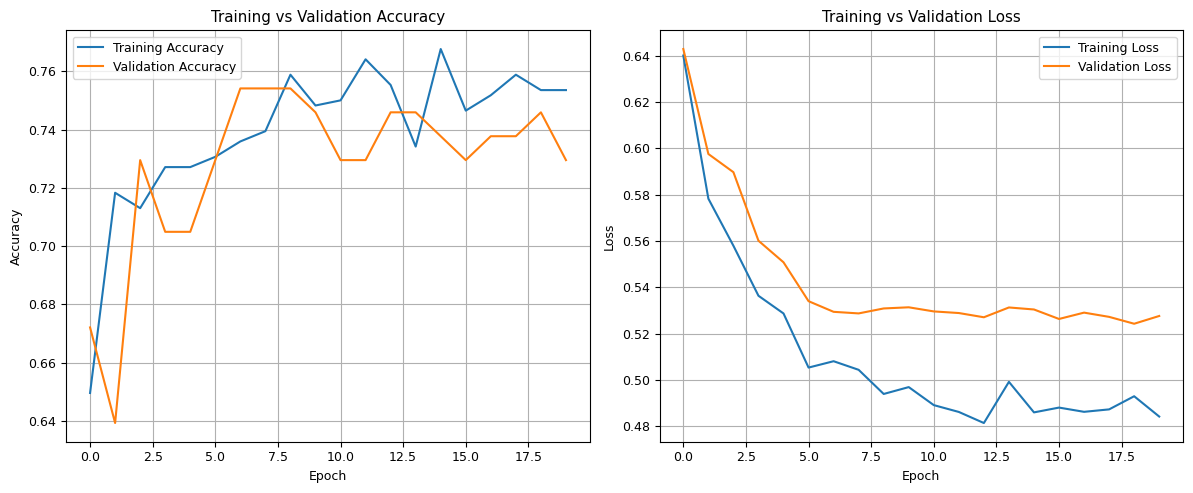


Final evaluation on the test set using the best model (based on validation performance):
Model will be saved to : baseline/model_CC_best_val_model.pth
Final Test Loss: 0.5651 Acc: 0.6934


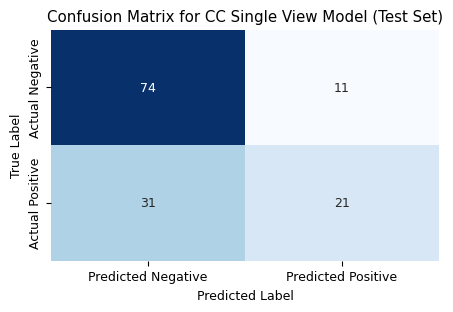

ROC AUC: 0.7495


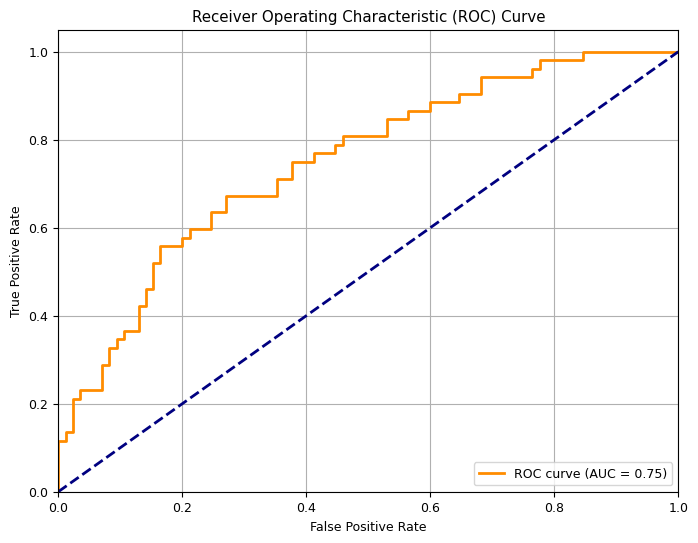

********************


In [ ]:
single_view_cc_cnn = SingleViewCNN(single_view_cc.torch_dataset_train_view,single_view_cc.torch_dataset_validation_view,single_view_cc.torch_dataset_test_view,"CC")

# To mitigate class imbalance we can use weights 
# Count class occurrences directly from the dataset
label_counts = Counter()
for _, label in single_view_cc.torch_dataset_train_view:  # Dataset returns (image, label)
    label_counts.update([label.item()])  # Ensure label is a scalar (not tensor)

num_classes = len(label_counts)
class_counts = torch.tensor([label_counts.get(i, 0) for i in range(num_classes)], dtype=torch.float)

# Compute class frequencies (normalize to sum to 1) and comput inverse of freqs
class_frequencies = class_counts / class_counts.sum()
inv_freqs = 1.0 / class_frequencies

if CONFIG["class_weight_type"]=="inv_norm" :
    #  Normalize weights (optional, for stability)  
    class_weights = inv_freqs / inv_freqs.sum()
    pos_weight = class_weights[1] / class_weights[0]
elif CONFIG["class_weight_type"] == "sqrt_inv_norm":
    inv_freqs = torch.sqrt(inv_freqs)  # or torch.log(1 + inv_freqs)
    class_weights = inv_freqs / inv_freqs.sum()   
    pos_weight = class_weights[1] / class_weights[0]
elif CONFIG["class_weight_type"] == "default":
    pos_weight = label_counts[0] / label_counts[1]
    pos_weight = torch.tensor([pos_weight], dtype=torch.float32) 
    print("label_counts[0] / label_counts[1]" , label_counts[0] , label_counts[1] )
elif CONFIG["class_weight_type"] is None:
    class_weights = None
    pos_weight = None

print("Inverse freqs: ", inv_freqs)

# Define loss function and optimizer, pass in class weights for use in the loss function 
single_view_cc_best_model_test_predictions, single_view_cc_all_test_labels, cc_performance_results = single_view_cc_cnn.Train(
    CONFIG['num_epochs'],CONFIG['patience'], CONFIG["test_name"], pos_weight=pos_weight)
print("*"*20)




Train DataLoader has 18 batches. Dataset size: 568
Validation DataLoader has 4 batches. Dataset size: 122
Test DataLoader has 5 batches. Dataset size: 137
Frozen all parameters except the final layer.
Modified ResNet50 final layer: Linear(in_features=2048, out_features=1, bias=True)

Starting training with validation and early stopping...
Epoch 1/20
----------
train Loss: 0.6521 Acc: 0.6268
val Loss: 0.6484 Acc: 0.6967
Validation loss improved to 0.6484. Saving model weights.
Epoch 2/20
----------
train Loss: 0.5922 Acc: 0.6884
val Loss: 0.6042 Acc: 0.7049
Validation loss improved to 0.6042. Saving model weights.
Epoch 3/20
----------
train Loss: 0.5610 Acc: 0.7130
val Loss: 0.5481 Acc: 0.7131
Validation loss improved to 0.5481. Saving model weights.
Epoch 4/20
----------
train Loss: 0.5448 Acc: 0.7236
val Loss: 0.5246 Acc: 0.6967
Validation loss improved to 0.5246. Saving model weights.
Epoch 5/20
----------
train Loss: 0.5223 Acc: 0.7377
val Loss: 0.5293 Acc: 0.6967
Validation loss 

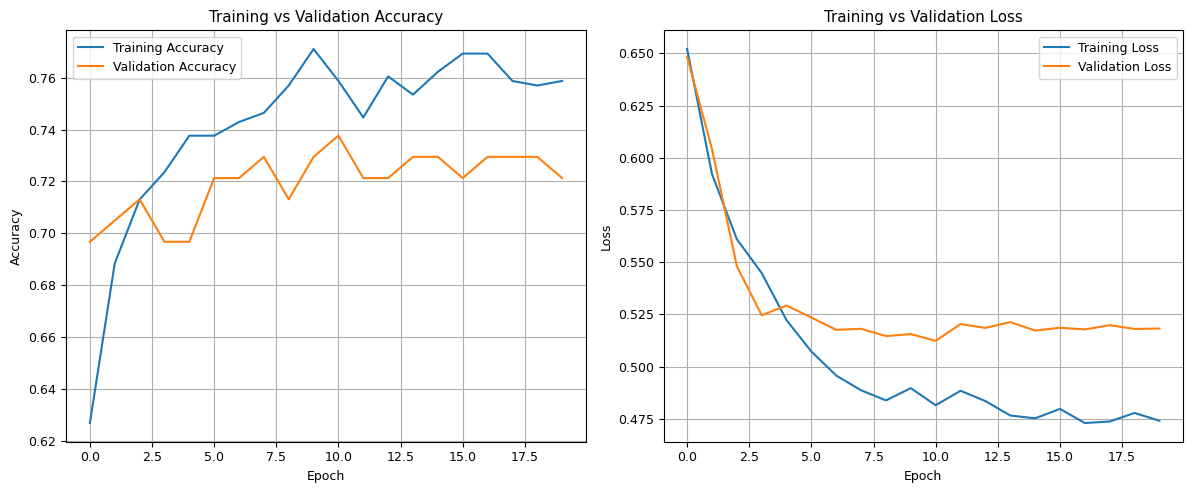


Final evaluation on the test set using the best model (based on validation performance):
Model will be saved to : baseline/model_MLO_best_val_model.pth
Final Test Loss: 0.5644 Acc: 0.6788


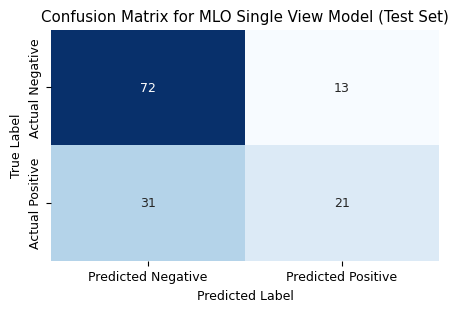

ROC AUC: 0.7489


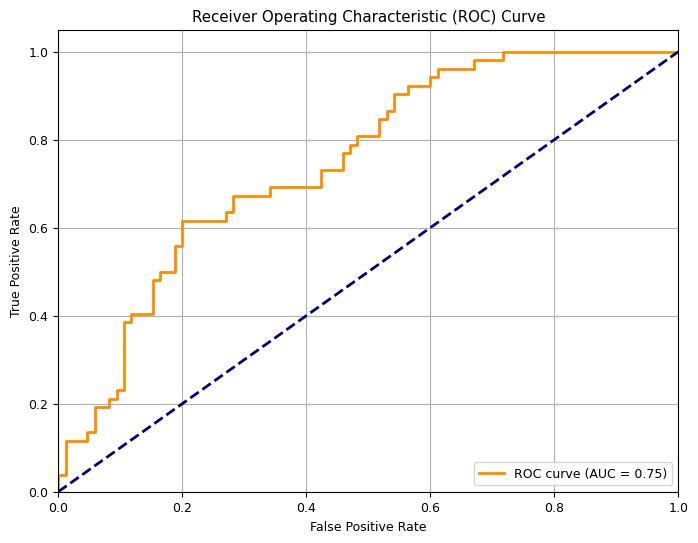

********************


In [138]:
single_view_mlo_cnn = SingleViewCNN(single_view_mlo.torch_dataset_train_view,single_view_mlo.torch_dataset_validation_view,single_view_mlo.torch_dataset_test_view,"MLO")
# Define loss function and optimizer
single_view_mlo_best_model_test_predictions, single_view_mlo_all_test_labels, mlo_performance_results = single_view_mlo_cnn.Train(
    CONFIG['num_epochs'],CONFIG['patience'], subdirectory=CONFIG["test_name"], pos_weight=pos_weight)
print("*"*20)

In [ ]:
# Create our multi view dataset
print("Multi-View Model")
train_dataset = MultiViewDataset([single_view_cc.torch_dataset_train_view, single_view_mlo.torch_dataset_train_view] )
val_dataset = MultiViewDataset([single_view_cc.torch_dataset_validation_view, single_view_mlo.torch_dataset_validation_view] )
test_dataset = MultiViewDataset([single_view_cc.torch_dataset_test_view, single_view_mlo.torch_dataset_test_view] )

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=int(CONFIG['mv_batch_size']), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=int(CONFIG['mv_batch_size']),  shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=int(CONFIG['mv_batch_size']),  shuffle=False)
print(f"Training samples: {len(train_dataset)}.  Validation samples: {len(val_dataset)}. Testing samples: {len(test_dataset)}.")


Multi-View Model
Training samples: 568.  Validation samples: 122. Testing samples: 137.


Starting training with validation and early stopping.
Epoch 1/30
----------

Epoch 1/30 - Training Phase
Train Results: Avg Loss: 72.3755, Accuracy: 0.5915

Epoch 1/30 - Validation Phase
Val Results: Avg Loss: 20.0559, Accuracy: 0.5902
Validation loss improved to 20.0559. Saving model weights.
Epoch 2/30
----------

Epoch 2/30 - Training Phase
Train Results: Avg Loss: 27.9734, Accuracy: 0.6461

Epoch 2/30 - Validation Phase
Val Results: Avg Loss: 7.6345, Accuracy: 0.7049
Validation loss improved to 7.6345. Saving model weights.
Epoch 3/30
----------

Epoch 3/30 - Training Phase
Train Results: Avg Loss: 14.4222, Accuracy: 0.6461

Epoch 3/30 - Validation Phase
Val Results: Avg Loss: 5.1294, Accuracy: 0.6475
Validation loss improved to 5.1294. Saving model weights.
Epoch 4/30
----------

Epoch 4/30 - Training Phase
Train Results: Avg Loss: 5.7466, Accuracy: 0.6532

Epoch 4/30 - Validation Phase
Val Results: Avg Loss: 2.0207, Accuracy: 0.6885
Validation loss improved to 2.0207. Saving mode

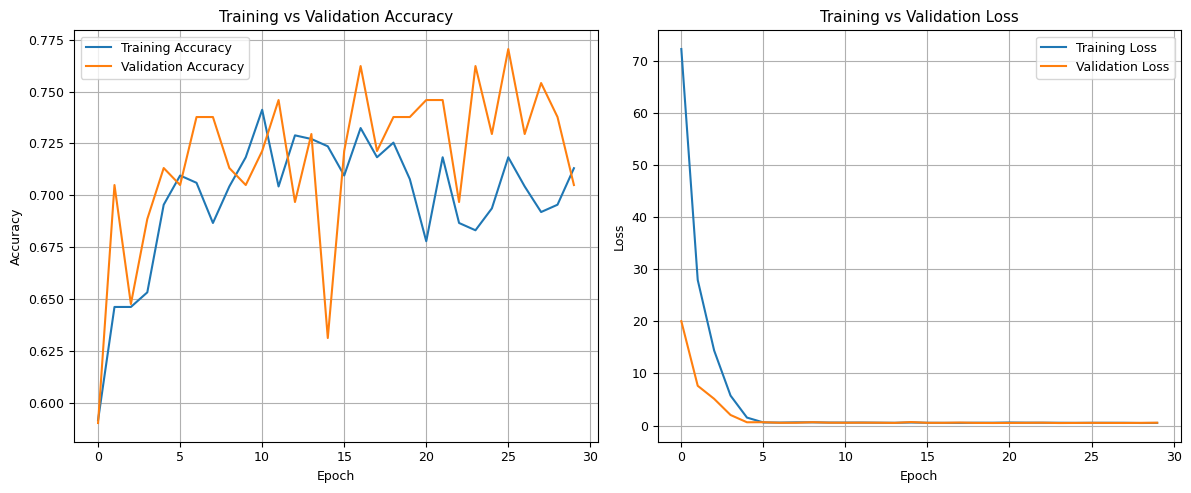


Starting evaluation...
Evaluation Complete. Test Accuracy: 0.7080


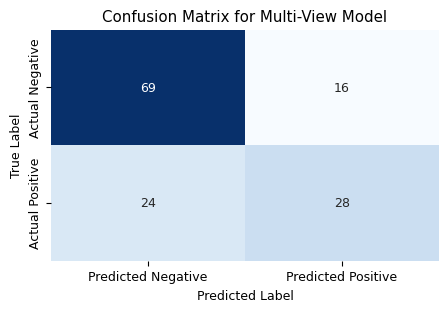

In evaluate_model tp, fp, tn, fn,  28 16 69 24
ROC AUC: 0.7692


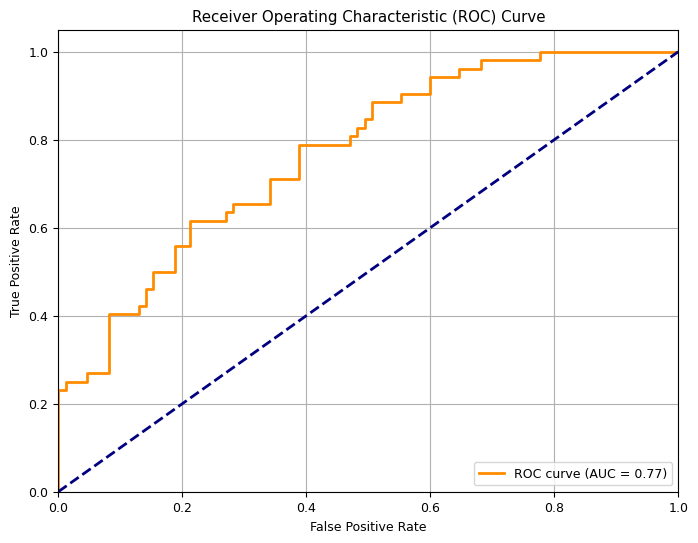

             CC SingleView Test  MLO SingleView Test  Multi-View Model
Accuracy               0.693431             0.678832          0.708029
Precision              0.656250             0.617647          0.636364
Recall                 0.403846             0.403846          0.538462
Specificity            0.870588             0.847059          0.811765
F1-Score               0.500000             0.488372          0.583333
TP                    21.000000            21.000000         28.000000
FP                    11.000000            13.000000         16.000000
TN                    74.000000            72.000000         69.000000
FN                    31.000000            31.000000         24.000000
AUC                    0.749548             0.748869          0.769231


In [ ]:

# Initialize the Late Fusion Fully Connected model
model = LateFusionFC(  num_classes=CONFIG['num_classes'],   num_views=CONFIG['num_views'],  feature_extractor_requires_grad=False 
).to(CONFIG['device']) 

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
# Adding in Learning Rate Decay
if CONFIG['lr_decay'] == True:
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
else:
    scheduler = None
# Training and evaluation of Multi View model 
mv_model, mv_best_model_state, mv_best_model_test_predictions, mv_all_test_labels = train_model(model, train_loader, val_loader,
test_loader, criterion, optimizer, CONFIG['device'], CONFIG['mv_num_epochs'], CONFIG['patience'],scheduler)

# Evaluate the model
test_accuracy, multi_performance_results = evaluate_model(model, test_loader, CONFIG['device'])
compare_performance_all_views(cc_performance_results, mlo_performance_results, multi_performance_results)

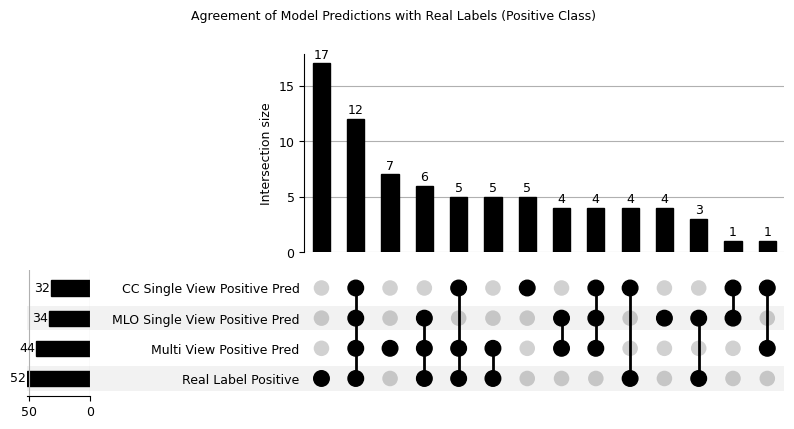

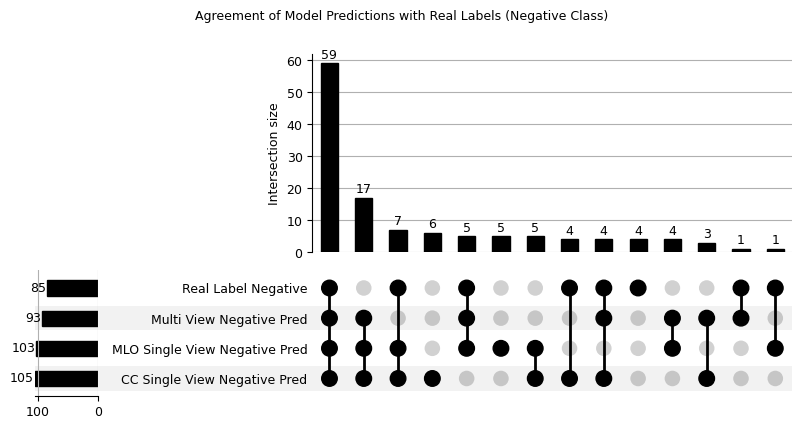

In [141]:
# Look at the classifications of all the models to see how they align with each other using Upset Plots
all_test_predictions = {
    'ground_truth': mv_all_test_labels ,
    'single_view_cc' : single_view_cc_best_model_test_predictions,
    'single_view_mlo' : single_view_mlo_best_model_test_predictions,
    'mv_view': mv_best_model_test_predictions }
df = pd.DataFrame(all_test_predictions)

# Indices for samples where Models and Ground Truth are predicted positive
model1_positive_samples = df[df['single_view_cc'] == 1].index.tolist()
model2_positive_samples = df[df['single_view_mlo'] == 1].index.tolist()
model3_positive_samples = df[df['mv_view'] == 1].index.tolist()
real_positive_samples = df[df['ground_truth'] == 1].index.tolist()

# Indices for samples where Models and Ground Truth are predicted negative
model1_negative_samples = df[df['single_view_cc'] == 0].index.tolist()
model2_negative_samples = df[df['single_view_mlo'] == 0].index.tolist()
model3_negative_samples = df[df['mv_view'] == 0].index.tolist()
real_negative_samples = df[df['ground_truth'] == 0].index.tolist()
pos_sets_data = from_contents({
    'Real Label Positive': real_positive_samples,
    'CC Single View Positive Pred': model1_positive_samples,
    'MLO Single View Positive Pred': model2_positive_samples,
    'Multi View Positive Pred': model3_positive_samples
})
neg_sets_data = from_contents({
    'Real Label Negative': real_negative_samples,
    'CC Single View Negative Pred': model1_negative_samples,
    'MLO Single View Negative Pred': model2_negative_samples,
    'Multi View Negative Pred': model3_negative_samples
})

# Plot the UpSet plot for the Positive classifications
plt.rcParams['font.size'] = 9
plot(pos_sets_data, show_counts=True, sort_by='cardinality', orientation='horizontal')
plt.suptitle('Agreement of Model Predictions with Real Labels (Positive Class)', fontsize=9)
plt.show()
# Plot the UpSet plot for the Negative classifications
plot(neg_sets_data, show_counts=True, sort_by='cardinality', orientation='horizontal')
plt.suptitle('Agreement of Model Predictions with Real Labels (Negative Class)', fontsize=9)
plt.show()

In [ ]:
# Score Fusion
@torch.no_grad()
def score_fusion_predict(models, dataloaders, fusion_type='sum', device='cpu'):
    """
    Performs score fusion from multiple trained single-view CNN models.
    
    Args:
        models (list[torch.nn.Module]): List of trained models (1 per view)
        dataloaders (list[torch.utils.data.DataLoader]): List of test dataloaders (1 per view)
        fusion_type (str): One of 'sum', 'product', or 'max'
        device (str): 'cuda' or 'cpu'

    Returns:
        fused_predictions: List of predicted class indices (0 or 1)
        all_labels: List of ground truth labels (assumed same across views)
    """
    assert fusion_type in ['sum', 'product', 'max']
    assert len(models) == len(dataloaders)

    num_views = len(models)
    all_class_probabilities = [] # Will store probabilities for BOTH classes (0 and 1)
    all_labels = []

    for model, loader in zip(models, dataloaders):
        model.eval()
        model.to(device)

        view_probs = []
        # We only need to collect labels once as assumed to be the same across views
        if not all_labels: 
            collected_labels = []

        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs) # These are the single logits from the ResNet's fc layer

            # Convert single logit to probabilities for two classes
        
            # P(class=1) = sigmoid(logit)
            # P(class=0) = 1 - sigmoid(logit)
            prob_positive_class = torch.sigmoid(outputs) # Shape: (batch_size, 1)
            prob_negative_class = 1 - prob_positive_class # Shape: (batch_size, 1)
            
            # Concatenate to get probabilities for both classes: (batch_size, 2)
            probs = torch.cat((prob_negative_class, prob_positive_class), dim=1)

            view_probs.append(probs.cpu())
            if not all_labels: # Collect labels only once
                collected_labels.extend(labels.cpu().numpy())
        
        all_class_probabilities.append(torch.cat(view_probs, dim=0))
        if not all_labels: # Assign collected labels after first view processing
            all_labels = collected_labels


    # Stack probabilities from all views: (num_views, num_samples, num_classes)
    probabilities_tensor = torch.stack(all_class_probabilities, dim=0)
    
    # Perform score fusion on probabilities
    if fusion_type == 'sum':
        fused_scores = torch.sum(probabilities_tensor, dim=0)
    elif fusion_type == 'product':
        fused_scores = torch.prod(probabilities_tensor, dim=0)
    elif fusion_type == 'max':
        fused_scores, _ = torch.max(probabilities_tensor, dim=0)

    # Final predictions from fused scores (argmax finds the class with highest score)
    fused_predictions = torch.argmax(fused_scores, dim=1).numpy()
    return fused_predictions, np.array(all_labels)

# Load each model and test dataset

view_names = ['CC', 'MLO'] 
loaded_models = []


cc_test_dataloader = DataLoader(single_view_cc.torch_dataset_test_view, batch_size=CONFIG['batch_size'], shuffle=False) # No shuffle for test
mlo_test_dataloader = DataLoader(single_view_mlo.torch_dataset_test_view, batch_size=CONFIG['batch_size'], shuffle=False) # No shuffle for test
from torchvision import models 
test_loaders_dict = {"CC": cc_test_dataloader, "MLO": mlo_test_dataloader}
test_loaders = []
test_name = CONFIG["test_name"]
for view in view_names:
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(2048, 1)
    
    model.load_state_dict(torch.load(f"./{test_name}/model_{view}_best_val_model.pth")) 
    model.to(device=CONFIG['device'])
    model.eval()
    loaded_models.append(model)

    test_loader_score_fusion =test_loaders_dict[view]
    test_loaders.append(test_loader_score_fusion)

# Run fusion to get predictions 
preds_sum, labels = score_fusion_predict(loaded_models, test_loaders, fusion_type='sum', device=CONFIG['device'])
preds_prod, _ = score_fusion_predict(loaded_models, test_loaders, fusion_type='product', device=CONFIG['device'])
preds_max, _ = score_fusion_predict(loaded_models, test_loaders, fusion_type='max', device=CONFIG['device'])

# Evaluate
from sklearn.metrics import classification_report
print("Sum Fusion:\n", classification_report(labels, preds_sum))
print("Product Fusion:\n", classification_report(labels, preds_prod))
print("Max Fusion:\n", classification_report(labels, preds_max))


Sum Fusion:
               precision    recall  f1-score   support

           0       0.71      0.91      0.79        85
           1       0.71      0.38      0.50        52

    accuracy                           0.71       137
   macro avg       0.71      0.65      0.65       137
weighted avg       0.71      0.71      0.68       137

Product Fusion:
               precision    recall  f1-score   support

           0       0.71      0.91      0.79        85
           1       0.71      0.38      0.50        52

    accuracy                           0.71       137
   macro avg       0.71      0.65      0.65       137
weighted avg       0.71      0.71      0.68       137

Max Fusion:
               precision    recall  f1-score   support

           0       0.71      0.91      0.79        85
           1       0.71      0.38      0.50        52

    accuracy                           0.71       137
   macro avg       0.71      0.65      0.65       137
weighted avg       0.71      0.

Score fusion showing no real improvement indicates the two views (CC and MLO) are not very complementary (i.e., they provide very similar information and make similar errors), so simply combining their scores is not adding much value. These fusion methods would have been better if the individual models were complementary. 

Calculate AUC and other performance metrics to 4.d.p for score fusion.

In [ ]:
def evaluate_metrics(y_true, y_pred, y_prob=None, print_label=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob[:, 1]) if y_prob is not None else None

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"--- {print_label} ---")
    print(f"Accuracy:     {acc:.4f}")
    print(f"Precision:    {prec:.4f}")
    print(f"Recall:       {rec:.4f}")
    print(f"Specificity:  {specificity:.4f}")
    print(f"F1-Score:     {f1:.4f}")
    print(f"TP:           {tp}")
    print(f"FP:           {fp}")
    print(f"TN:           {tn}")
    print(f"FN:           {fn}")
    print(f"AUC:          {auc:.4f}" if auc is not None else "AUC:          N/A")

# Run fusion
preds_sum, labels = score_fusion_predict(loaded_models, test_loaders, fusion_type='sum', device=CONFIG['device'])
preds_prod, _ = score_fusion_predict(loaded_models, test_loaders, fusion_type='product', device=CONFIG['device'])
preds_max, _ = score_fusion_predict(loaded_models, test_loaders, fusion_type='max', device=CONFIG['device'])

# Get fused class probabilities to compute AUC
# Re-run one fusion to get fused scores
@torch.no_grad()
def get_fused_probs(models, dataloaders, fusion_type='sum', device='cpu'):
    all_class_probabilities = []
    for model, loader in zip(models, dataloaders):
        model.eval()
        model.to(device)
        view_probs = []
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            prob_positive = torch.sigmoid(outputs)
            prob_negative = 1 - prob_positive
            probs = torch.cat((prob_negative, prob_positive), dim=1)
            view_probs.append(probs.cpu())
        all_class_probabilities.append(torch.cat(view_probs, dim=0))
    
    probabilities_tensor = torch.stack(all_class_probabilities, dim=0)
    if fusion_type == 'sum':
        fused_scores = torch.sum(probabilities_tensor, dim=0)
    elif fusion_type == 'product':
        fused_scores = torch.prod(probabilities_tensor, dim=0)
    elif fusion_type == 'max':
        fused_scores, _ = torch.max(probabilities_tensor, dim=0)
    return fused_scores.numpy()

# Get class probabilities for AUC
probs_sum = get_fused_probs(loaded_models, test_loaders, fusion_type='sum', device=CONFIG['device'])
probs_prod = get_fused_probs(loaded_models, test_loaders, fusion_type='product', device=CONFIG['device'])
probs_max = get_fused_probs(loaded_models, test_loaders, fusion_type='max', device=CONFIG['device'])

# Evaluate with extended metrics
evaluate_metrics(labels, preds_sum, probs_sum, print_label="Sum Fusion")
evaluate_metrics(labels, preds_prod, probs_prod, print_label="Product Fusion")
evaluate_metrics(labels, preds_max, probs_max, print_label="Max Fusion")

--- Sum Fusion ---
Accuracy:     0.7080
Precision:    0.7143
Recall:       0.3846
Specificity:  0.9059
F1-Score:     0.5000
TP:           20
FP:           8
TN:           77
FN:           32
AUC:          0.7742
--- Product Fusion ---
Accuracy:     0.7080
Precision:    0.7143
Recall:       0.3846
Specificity:  0.9059
F1-Score:     0.5000
TP:           20
FP:           8
TN:           77
FN:           32
AUC:          0.7722
--- Max Fusion ---
Accuracy:     0.7080
Precision:    0.7143
Recall:       0.3846
Specificity:  0.9059
F1-Score:     0.5000
TP:           20
FP:           8
TN:           77
FN:           32
AUC:          0.7724


In [ ]:
#  Extract predictions from existing dictionary 
true_labels = np.array(all_test_predictions['ground_truth'])
cc_preds = np.array(all_test_predictions['single_view_cc'])
mlo_preds = np.array(all_test_predictions['single_view_mlo'])

#  Individual View Performance 
print("\n--- Individual View Performance ---")
# Ensure the lengths match, otherwise comparisons will fail or be meaningless
if len(true_labels) != len(cc_preds) or len(true_labels) != len(mlo_preds):
    print("WARNING: Lengths of true_labels and predictions do not match!")
    print(f"True labels length: {len(true_labels)}")
    print(f"CC predictions length: {len(cc_preds)}")
    print(f"MLO predictions length: {len(mlo_preds)}")

print(f"CC Accuracy: {np.mean(cc_preds == true_labels):.4f}")
print(f"MLO Accuracy: {np.mean(mlo_preds == true_labels):.4f}")

# --- Identify Misclassified Samples for each view ---
cc_misclassified_indices = np.where(cc_preds != true_labels)[0]
mlo_misclassified_indices = np.where(mlo_preds != true_labels)[0]

print(f"\nNumber of misclassified samples by CC: {len(cc_misclassified_indices)}")
print(f"Number of misclassified samples by MLO: {len(mlo_misclassified_indices)}")

# ---  Compare and find overlap ---
# Convert to sets for easy intersection calculation
cc_misclassified_set = set(cc_misclassified_indices)
mlo_misclassified_set = set(mlo_misclassified_indices)

# Samples misclassified by BOTH views
overlap_misclassified_indices = cc_misclassified_set.intersection(mlo_misclassified_set)
num_overlap_misclassified = len(overlap_misclassified_indices)

# Samples misclassified by CC but NOT MLO (complementary errors for MLO)
cc_only_misclassified = cc_misclassified_set.difference(mlo_misclassified_set)
num_cc_only = len(cc_only_misclassified)

# Samples misclassified by MLO but NOT CC (complementary errors for CC)
mlo_only_misclassified = mlo_misclassified_set.difference(cc_misclassified_set)
num_mlo_only = len(mlo_only_misclassified)

print("\n--- Misclassification Overlap Analysis ---")
print(f"Samples misclassified by BOTH CC and MLO: {num_overlap_misclassified}")
print(f"Samples misclassified by ONLY CC: {num_cc_only}")
print(f"Samples misclassified by ONLY MLO: {num_mlo_only}")

# Total unique misclassified samples (for sanity check: should be sum of the three above)
total_unique_misclassified = len(cc_misclassified_set.union(mlo_misclassified_set))
print(f"Total unique samples misclassified by at least one view: {total_unique_misclassified}")

# --- Interpretation Hints ---
print("\n--- Interpretation ---")
if len(cc_misclassified_indices) > 0 and len(mlo_misclassified_indices) > 0: # Avoid division by zero if no errors
    if num_overlap_misclassified / min(len(cc_misclassified_indices), len(mlo_misclassified_indices)) > 0.5:
        print("High overlap in misclassified samples. This suggests the views are making similar errors.")
        print("Simple score fusion might not yield large gains because the models are redundant in their mistakes.")
        print("Consider: Feature-level fusion, more complex learnable fusion, or improving individual models first.")
    elif num_cc_only > 0 and num_mlo_only > 0:
        print("Significant number of samples misclassified by only one view.")
        print("This indicates complementarity, which is good! Score fusion (especially max or weighted sum) should ideally benefit from this.")
        print("If fusion didn't improve much, consider weighted fusion or a learnable fusion layer.")
    else:
        print("The error patterns are not clearly highly overlapping or highly complementary.")
        print("Further investigation into specific sample errors might be needed.")
else:
    print("One or both models have no misclassified samples, or an issue occurred preventing proper calculation.")


# Example: Display a few indices from each category
if num_overlap_misclassified > 0:
    print(f"\nExample indices misclassified by BOTH: {list(overlap_misclassified_indices)[:5]}")
if num_cc_only > 0:
    print(f"Example indices misclassified by ONLY CC: {list(cc_only_misclassified)[:5]}")
if num_mlo_only > 0:
    print(f"Example indices misclassified by ONLY MLO: {list(mlo_only_misclassified)[:5]}")




--- Individual View Performance ---
CC Accuracy: 0.6934
MLO Accuracy: 0.6788

Number of misclassified samples by CC: 42
Number of misclassified samples by MLO: 44

--- Misclassification Overlap Analysis ---
Samples misclassified by BOTH CC and MLO: 27
Samples misclassified by ONLY CC: 15
Samples misclassified by ONLY MLO: 17
Total unique samples misclassified by at least one view: 59

--- Interpretation ---
High overlap in misclassified samples. This suggests the views are making similar errors.
Simple score fusion might not yield large gains because the models are redundant in their mistakes.
Consider: Feature-level fusion, more complex learnable fusion, or improving individual models first.

Example indices misclassified by BOTH: [np.int64(129), np.int64(5), np.int64(7), np.int64(136), np.int64(13)]
Example indices misclassified by ONLY CC: [np.int64(0), np.int64(33), np.int64(67), np.int64(70), np.int64(14)]
Example indices misclassified by ONLY MLO: [np.int64(64), np.int64(121), n

RandomNoiseDataset created with 568 images.
Image shape: (3, 224, 224)
Label distribution (approx): 285 zeros, 283 ones.
RandomNoiseDataset created with 122 images.
Image shape: (3, 224, 224)
Label distribution (approx): 73 zeros, 49 ones.
RandomNoiseDataset created with 137 images.
Image shape: (3, 224, 224)
Label distribution (approx): 73 zeros, 64 ones.

Train DataLoader has 18 batches. Dataset size: 568
Validation DataLoader has 4 batches. Dataset size: 122
Test DataLoader has 5 batches. Dataset size: 137
Frozen all parameters except the final layer.
Modified ResNet50 final layer: Linear(in_features=2048, out_features=1, bias=True)

Starting training with validation and early stopping...
Epoch 1/20
----------
train Loss: 0.6956 Acc: 0.4912
val Loss: 0.6956 Acc: 0.4426
Validation loss improved to 0.6956. Saving model weights.
Epoch 2/20
----------
train Loss: 0.6807 Acc: 0.5915
val Loss: 0.6943 Acc: 0.5164
Validation loss improved to 0.6943. Saving model weights.
Epoch 3/20
--------

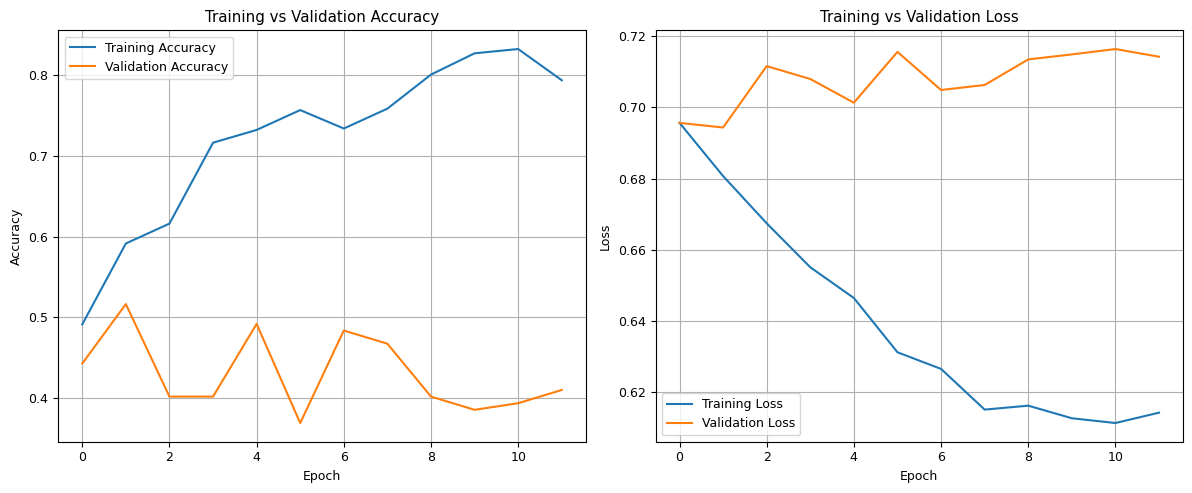


Final evaluation on the test set using the best model (based on validation performance):
Model will be saved to : ./model_Noise_best_val_model.pth
Final Test Loss: 0.6907 Acc: 0.5036


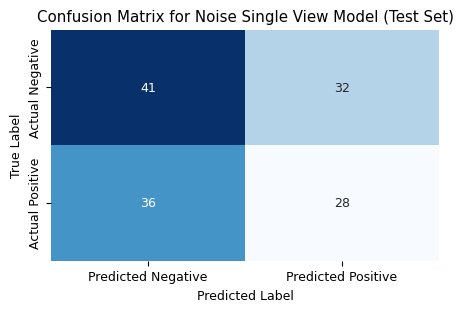

ROC AUC: 0.5146


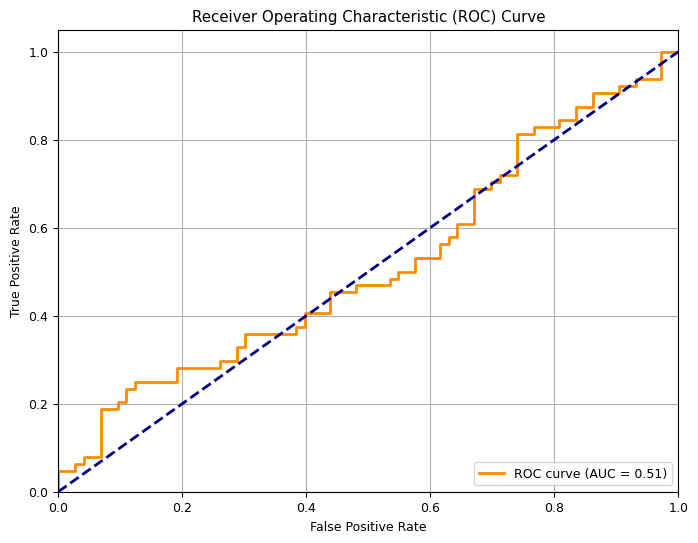

********************


In [ ]:
# Create Noise datasets of equivalent sizes, these are pure noise and show that the way we create a SingleViewCNN is 
# working and the accuracy is about .5 on the test dataset
noise_train_dataset = RandomNoiseDataset(len(single_view_mlo.torch_dataset_train_view))
noise_val_dataset = RandomNoiseDataset(len(single_view_mlo.torch_dataset_validation_view))
noise_test_dataset = RandomNoiseDataset(len(single_view_mlo.torch_dataset_test_view))

noise_cnn = SingleViewCNN(noise_train_dataset,noise_val_dataset,noise_test_dataset,"Noise")
# Define loss function and optimizer
noise_best_model_test_predictions, noise_all_test_labels, noise_performance_results = noise_cnn.Train(
    CONFIG['num_epochs'],CONFIG['patience'])
print("*"*20)

Starting training with validation and early stopping.
Epoch 1/30
----------

Epoch 1/30 - Training Phase
Train Results: Avg Loss: 18.9810, Accuracy: 0.3539

Epoch 1/30 - Validation Phase
Val Results: Avg Loss: 8.6967, Accuracy: 0.4016
Validation loss improved to 8.6967. Saving model weights.
Epoch 2/30
----------

Epoch 2/30 - Training Phase
Train Results: Avg Loss: 6.1574, Accuracy: 0.4859

Epoch 2/30 - Validation Phase
Val Results: Avg Loss: 5.0779, Accuracy: 0.5738
Validation loss improved to 5.0779. Saving model weights.
Epoch 3/30
----------

Epoch 3/30 - Training Phase
Train Results: Avg Loss: 5.3649, Accuracy: 0.5528

Epoch 3/30 - Validation Phase
Val Results: Avg Loss: 5.2508, Accuracy: 0.5246
Validation loss did not improve. Patience: 1/10
Epoch 4/30
----------

Epoch 4/30 - Training Phase
Train Results: Avg Loss: 5.0386, Accuracy: 0.5511

Epoch 4/30 - Validation Phase
Val Results: Avg Loss: 5.1266, Accuracy: 0.5656
Validation loss did not improve. Patience: 2/10
Epoch 5/30
--

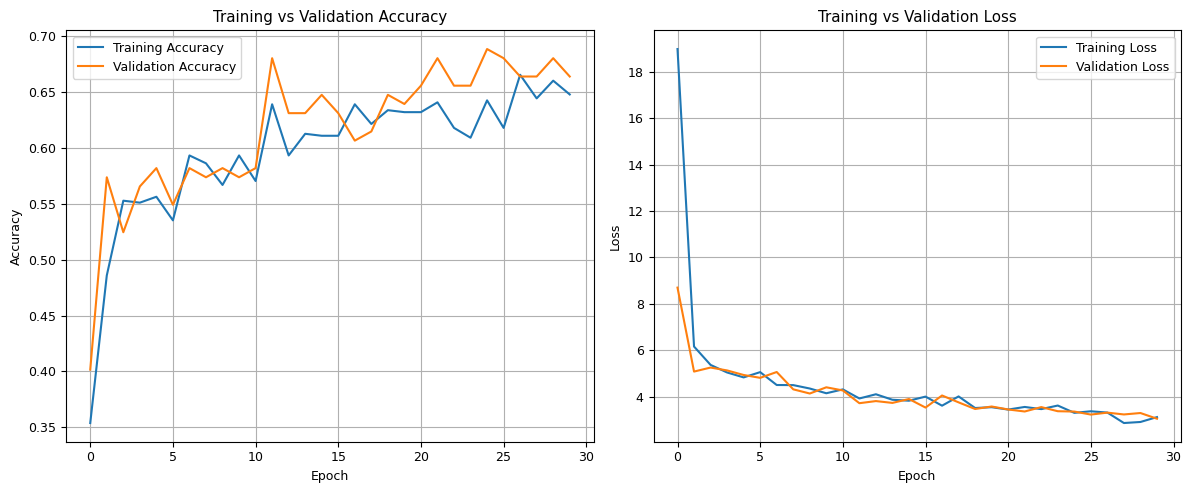


Starting evaluation...
Evaluation Complete. Test Accuracy: 0.5474


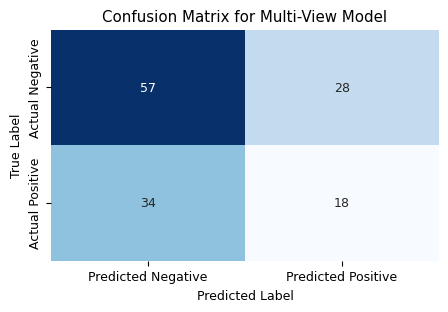

In evaluate_model tp, fp, tn, fn,  18 28 57 34
ROC AUC: 0.5459


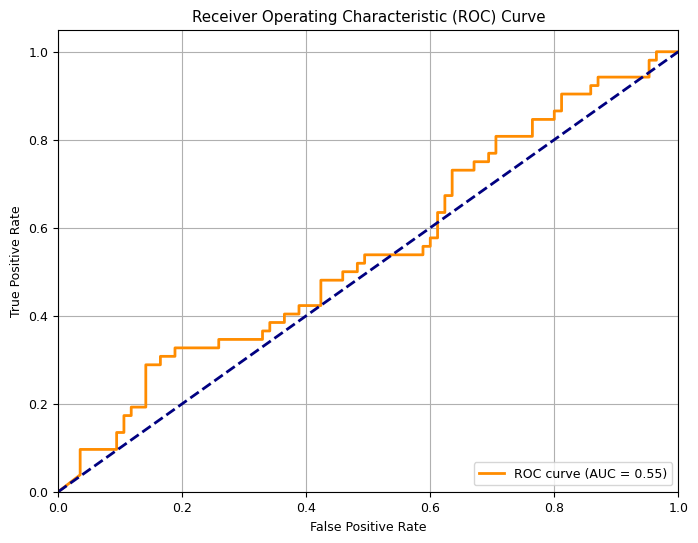

             CC SingleView Test  MLO SingleView Test  Multi-View Model
Accuracy               0.693431             0.678832          0.547445
Precision              0.656250             0.617647          0.391304
Recall                 0.403846             0.403846          0.346154
Specificity            0.870588             0.847059          0.670588
F1-Score               0.500000             0.488372          0.367347
TP                    21.000000            21.000000         18.000000
FP                    11.000000            13.000000         28.000000
TN                    74.000000            72.000000         57.000000
FN                    31.000000            31.000000         34.000000
AUC                    0.749548             0.748869          0.545928


In [ ]:
# Test Weighted Late Fusion FC MultiView  
from weight_late_fusion_fc import WeightedSumFusionModel
from torch.optim import lr_scheduler

ws_model = WeightedSumFusionModel(  num_classes=CONFIG['num_classes'], num_views=2,requires_grad_extractor=False 
).to(CONFIG['device'])

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(ws_model.parameters(), lr=CONFIG['learning_rate'])

ws_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Start training and evaluation of Multi View model 
mv_model, mv_best_model_state, mv_best_model_test_predictions, mv_all_test_labels = train_model(ws_model, train_loader, val_loader,
test_loader, criterion, optimizer, CONFIG['device'], CONFIG['mv_num_epochs'], CONFIG['patience'],scheduler)

# Evaluate the model
test_accuracy, multi_performance_results = evaluate_model(ws_model, test_loader, CONFIG['device'])
compare_performance_all_views(cc_performance_results, mlo_performance_results, multi_performance_results)

Starting training with validation and early stopping.
Epoch 1/30
----------

Epoch 1/30 - Training Phase
Train Results: Avg Loss: 5.5887, Accuracy: 0.5704

Epoch 1/30 - Validation Phase
Val Results: Avg Loss: 6.8592, Accuracy: 0.5656
Validation loss improved to 6.8592. Saving model weights.
Epoch 2/30
----------

Epoch 2/30 - Training Phase
Train Results: Avg Loss: 5.6908, Accuracy: 0.5669

Epoch 2/30 - Validation Phase
Val Results: Avg Loss: 6.3365, Accuracy: 0.4836
Validation loss improved to 6.3365. Saving model weights.
Epoch 3/30
----------

Epoch 3/30 - Training Phase
Train Results: Avg Loss: 4.4598, Accuracy: 0.6109

Epoch 3/30 - Validation Phase
Val Results: Avg Loss: 6.5003, Accuracy: 0.4590
Validation loss did not improve. Patience: 1/10
Epoch 4/30
----------

Epoch 4/30 - Training Phase
Train Results: Avg Loss: 4.6180, Accuracy: 0.6021

Epoch 4/30 - Validation Phase
Val Results: Avg Loss: 5.7021, Accuracy: 0.4180
Validation loss improved to 5.7021. Saving model weights.
Epoc

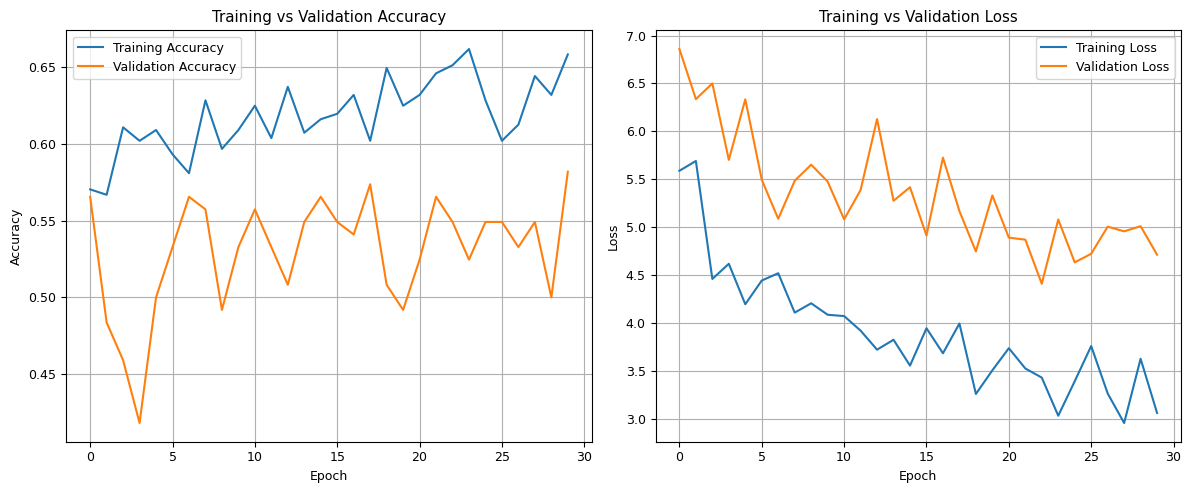


Starting evaluation...
Evaluation Complete. Test Accuracy: 0.5620


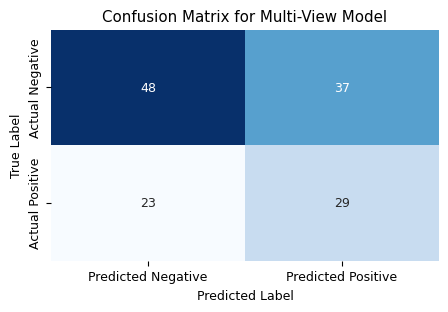

In evaluate_model tp, fp, tn, fn,  29 37 48 23
ROC AUC: 0.5777


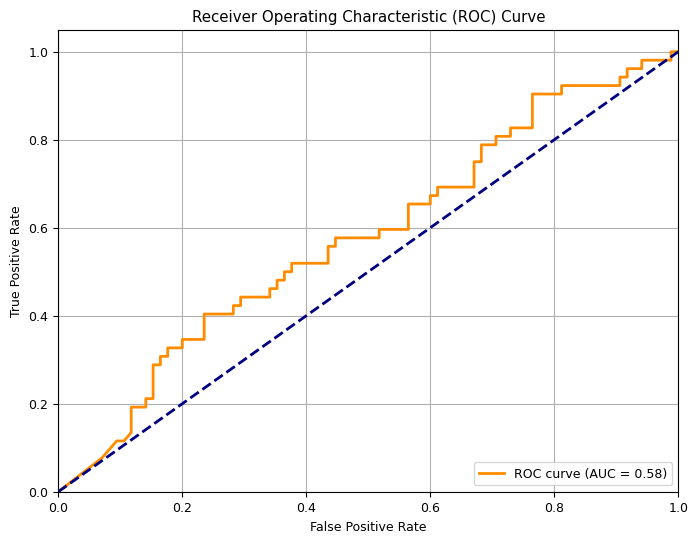

             CC SingleView Test  MLO SingleView Test  Multi-View Model
Accuracy               0.693431             0.678832          0.562044
Precision              0.656250             0.617647          0.439394
Recall                 0.403846             0.403846          0.557692
Specificity            0.870588             0.847059          0.564706
F1-Score               0.500000             0.488372          0.491525
TP                    21.000000            21.000000         29.000000
FP                    11.000000            13.000000         37.000000
TN                    74.000000            72.000000         48.000000
FN                    31.000000            31.000000         23.000000
AUC                    0.749548             0.748869          0.577715


In [ ]:
# AttentionFusion method

af_model = AttentionFusion(  num_classes=CONFIG['num_classes'], num_views=2,requires_grad_extractor=False 
).to(CONFIG['device']) 

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(af_model.parameters(), lr=CONFIG['learning_rate'])
# Adding in Learning Rate Decay - Better results without the scheduler 
att_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Start training and evaluation of Multi View model 
mv_model, mv_best_model_state, mv_best_model_test_predictions, mv_all_test_labels = train_model(af_model, train_loader, val_loader,
test_loader, criterion, optimizer, CONFIG['device'], CONFIG['mv_num_epochs'], CONFIG['patience'],scheduler)

# Evaluate the model
test_accuracy, multi_performance_results = evaluate_model(af_model, test_loader, CONFIG['device'])
compare_performance_all_views(cc_performance_results, mlo_performance_results, multi_performance_results)


--- Initializing and Training Mixture of Experts (MoE) Model ---
Expert models (CC and MLO ResNet50s) frozen.

Trainable parameters in MoE model:
gating_network.0.weight
gating_network.0.bias
gating_network.2.weight
gating_network.2.bias
Starting training with validation and early stopping.
Epoch 1/30
----------

Epoch 1/30 - Training Phase
  [DEBUG] Epoch 1, Batch 0/35
    0.weight grad norm: 0.28224725
    0.bias grad norm: 0.02174800
    2.weight grad norm: 0.02173664
    2.bias grad norm: 0.00194447
    Gating Raw Scores (mean): [-6.738959  4.999896]
    Gating Raw Scores (min/max): -26.9554/21.0174
    Gating Weights (mean): [0.15534002 0.84466004]
    Gating Weights (min/max): 0.0000/1.0000
  [DEBUG] Epoch 1, Batch 5/35
    0.weight grad norm: 0.00077381
    0.bias grad norm: 0.00006623
    2.weight grad norm: 0.00006526
    2.bias grad norm: 0.00000588
    Gating Raw Scores (mean): [-13.830902  15.70158 ]
    Gating Raw Scores (min/max): -24.6422/31.9493
    Gating Weights (mea

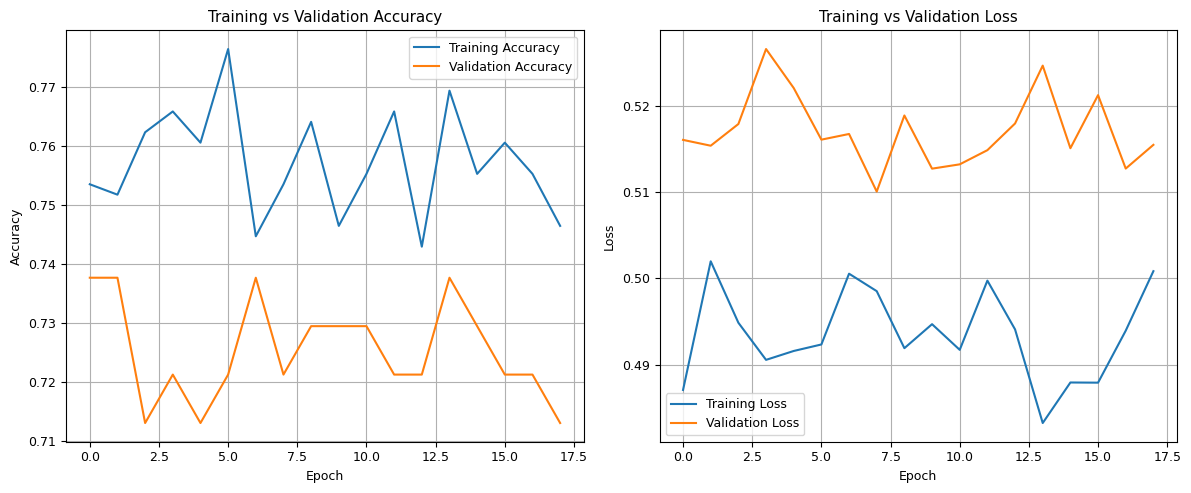

In [ ]:
# Try Mixture of Experts

# We use our pretrained Single View CNNs 
# Load the trained model's state_dict into a clean ResNet50 model
cc_base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
cc_base_model.fc = nn.Linear(cc_base_model.fc.in_features, CONFIG['num_classes'])
cc_base_model.load_state_dict(torch.load(single_view_cc_cnn.saved_model_path))
cc_base_model = cc_base_model.to(CONFIG['device'])

# Load the trained model's state_dict into a clean ResNet50 model
mlo_base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
mlo_base_model.fc = nn.Linear(mlo_base_model.fc.in_features, CONFIG['num_classes'])
mlo_base_model.load_state_dict(torch.load(single_view_mlo_cnn.saved_model_path))
mlo_base_model = mlo_base_model.to(CONFIG['device'])

print("\n--- Initializing and Training Mixture of Experts (MoE) Model ---")
moe_model = MoEViewFusion(
    num_classes=CONFIG['num_classes'],
    cc_expert_resnet=cc_base_model, # Pass the actual ResNet50 nn.Module
    mlo_expert_resnet=mlo_base_model, # Pass the actual ResNet50 nn.Module
    freeze_experts=True # Set to False to fine-tune experts during MoE training
).to(CONFIG['device'])

# Print trainable parameters to confirm only gating network is trainable if frozen_experts=True
print("\nTrainable parameters in MoE model:")
for name, param in moe_model.named_parameters():
    if param.requires_grad:
        print(name)

# Define optimizer and scheduler for the MoE model (only for gating network)
criterion_moe = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
optimizer_moe = torch.optim.Adam(moe_model.gating_network.parameters(), lr=1e-4) # Only optimizing gating network
scheduler_moe = lr_scheduler.StepLR(optimizer_moe, step_size=7, gamma=0.1)
#scheduler_moe = scheduler

# Start training and evaluation of Multi View model 
mv_model, mv_best_model_state, mv_best_model_test_predictions, mv_all_test_labels = train_model(moe_model, train_loader, val_loader,
test_loader, criterion_moe, optimizer_moe, CONFIG['device'], CONFIG['mv_num_epochs'], CONFIG['patience'],scheduler_moe)




Starting evaluation...


Evaluation Complete. Test Accuracy: 0.6934


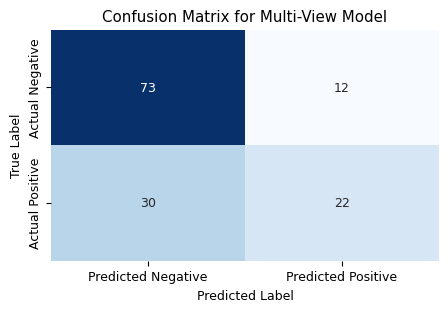

In evaluate_model tp, fp, tn, fn,  22 12 73 30
ROC AUC: 0.7452


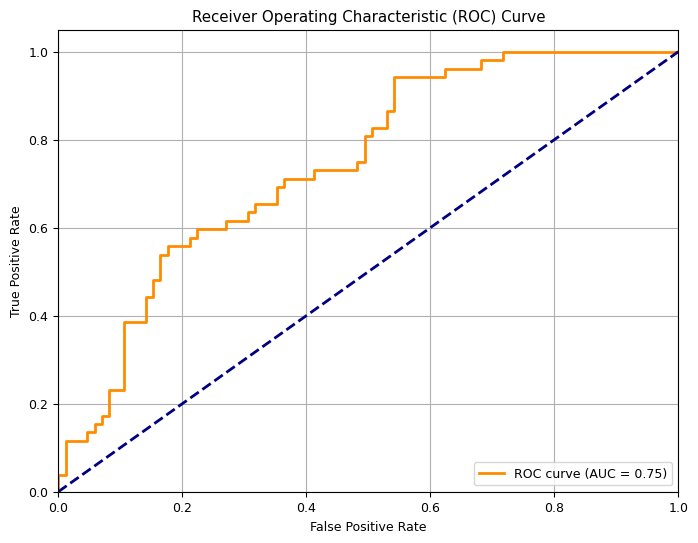

             CC SingleView Test  MLO SingleView Test  Multi-View Model
Accuracy               0.693431             0.678832          0.693431
Precision              0.656250             0.617647          0.647059
Recall                 0.403846             0.403846          0.423077
Specificity            0.870588             0.847059          0.858824
F1-Score               0.500000             0.488372          0.511628
TP                    21.000000            21.000000         22.000000
FP                    11.000000            13.000000         12.000000
TN                    74.000000            72.000000         73.000000
FN                    31.000000            31.000000         30.000000
AUC                    0.749548             0.748869          0.745249


In [149]:
# Evaluate the model
test_accuracy, multi_performance_results = evaluate_model(moe_model, test_loader, CONFIG['device'])
compare_performance_all_views(cc_performance_results, mlo_performance_results, multi_performance_results)


# Test the LateFusionCustomClassifier Model

Starting training with validation and early stopping.
Epoch 1/30
----------

Epoch 1/30 - Training Phase
Train Results: Avg Loss: 45.8453, Accuracy: 0.5528

Epoch 1/30 - Validation Phase
Val Results: Avg Loss: 18.2962, Accuracy: 0.3443
Validation loss improved to 18.2962. Saving model weights.
Epoch 2/30
----------

Epoch 2/30 - Training Phase
Train Results: Avg Loss: 30.9277, Accuracy: 0.5792

Epoch 2/30 - Validation Phase
Val Results: Avg Loss: 3.1810, Accuracy: 0.6639
Validation loss improved to 3.1810. Saving model weights.
Epoch 3/30
----------

Epoch 3/30 - Training Phase
Train Results: Avg Loss: 22.5941, Accuracy: 0.5898

Epoch 3/30 - Validation Phase
Val Results: Avg Loss: 1.8183, Accuracy: 0.6557
Validation loss improved to 1.8183. Saving model weights.
Epoch 4/30
----------

Epoch 4/30 - Training Phase
Train Results: Avg Loss: 14.5354, Accuracy: 0.5475

Epoch 4/30 - Validation Phase
Val Results: Avg Loss: 4.1841, Accuracy: 0.6557
Validation loss did not improve. Patience: 1/1

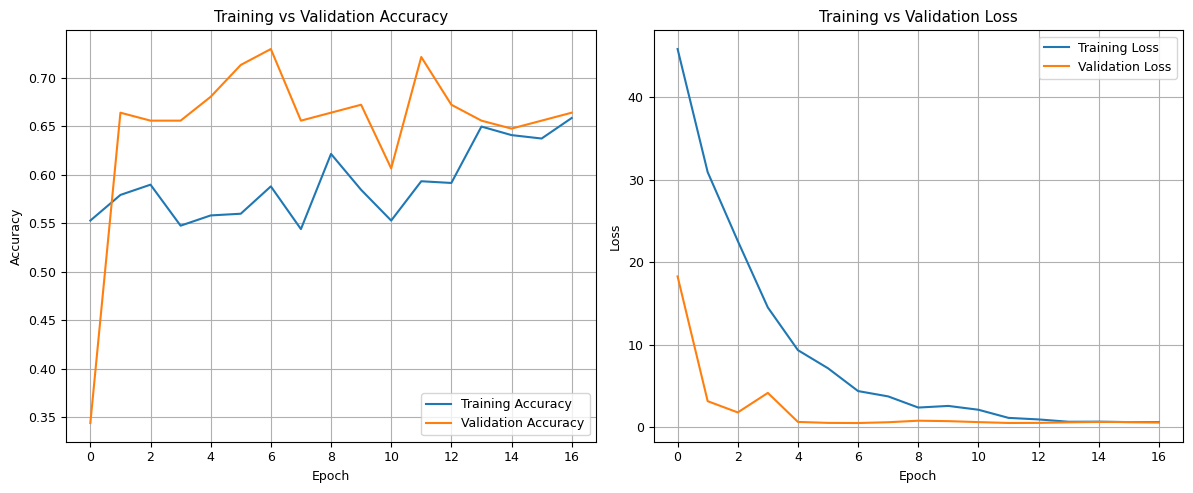


Starting evaluation...
Evaluation Complete. Test Accuracy: 0.6715


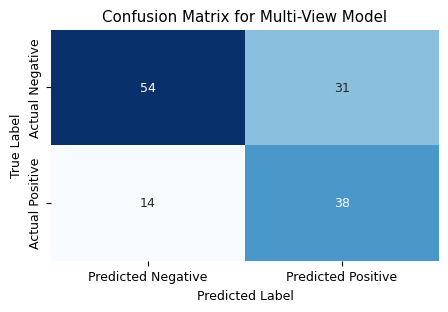

In evaluate_model tp, fp, tn, fn,  38 31 54 14
ROC AUC: 0.7566


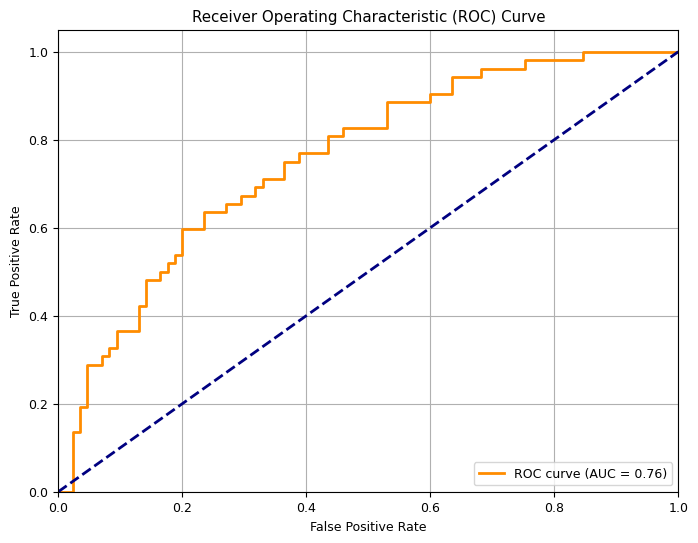

             CC SingleView Test  MLO SingleView Test  Multi-View Model
Accuracy               0.693431             0.678832          0.671533
Precision              0.656250             0.617647          0.550725
Recall                 0.403846             0.403846          0.730769
Specificity            0.870588             0.847059          0.635294
F1-Score               0.500000             0.488372          0.628099
TP                    21.000000            21.000000         38.000000
FP                    11.000000            13.000000         31.000000
TN                    74.000000            72.000000         54.000000
FN                    31.000000            31.000000         14.000000
AUC                    0.749548             0.748869          0.756561


In [ ]:
from late_fusion_fc_custom import LateFusionCustomClassifier
# Initialize the Late Fusion Fully Connected model
model = LateFusionCustomClassifier(  num_classes=CONFIG['num_classes'],   num_views=CONFIG['num_views'],  feature_extractor_requires_grad=False 
).to(CONFIG['device']) 

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Training and evaluation of Multi View model 
mv_model, mv_best_model_state, mv_best_model_test_predictions, mv_all_test_labels = train_model(model, train_loader, val_loader,
test_loader, criterion, optimizer, CONFIG['device'], CONFIG['mv_num_epochs'], CONFIG['patience'],scheduler)

# Evaluate the model
test_accuracy, multi_performance_results = evaluate_model(model, test_loader, CONFIG['device'])
compare_performance_all_views(cc_performance_results, mlo_performance_results, multi_performance_results)

# Test LateFusionLR  - Renamed to MVS LR in report (Multi-View Stacking using Logistic Regression)
This model uses separate trained resnet50 models for the MLO and CC images, then gets the logits which are use to train a logistic regression model.  


--- Instantiating Fusion Model with pre-trained CNNs ---

--- Training Fusion Pipeline (using pre-trained CNNs) ---

--- Stage 1: Using Pre-trained CC SingleViewCNN Model ---

--- Stage 1: Using Pre-trained MLO SingleViewCNN Model ---

--- Stage 2: Extracting Logits and Training Logistic Regression ---
Loaded best trained model for CC from baseline/model_CC_best_val_model.pth
DEBUG : running_corrects 431 and dataset size 568
Final CC Train Logit Extraction Logit Extraction Loss: 0.4707 Acc: 0.7588


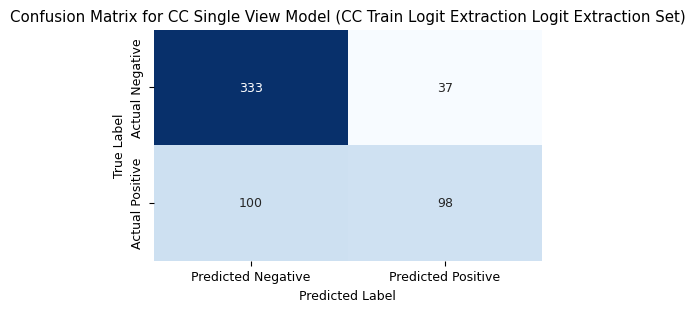

ROC AUC: 0.8511


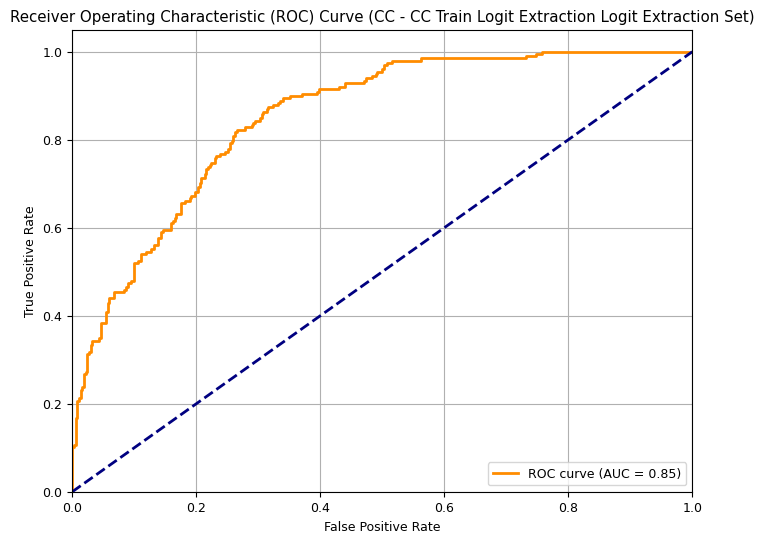

Loaded best trained model for MLO from baseline/model_MLO_best_val_model.pth
DEBUG : running_corrects 436 and dataset size 568
Final MLO Train Logit Extraction Logit Extraction Loss: 0.4673 Acc: 0.7676


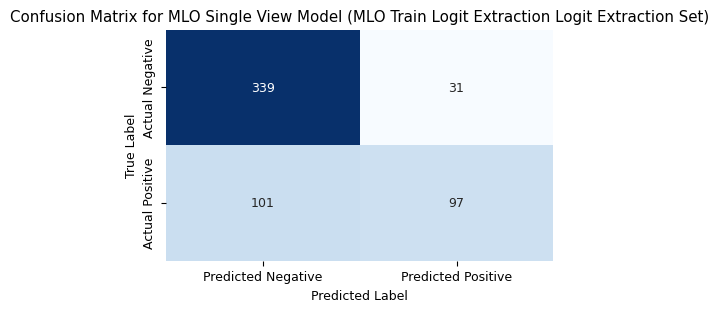

ROC AUC: 0.8655


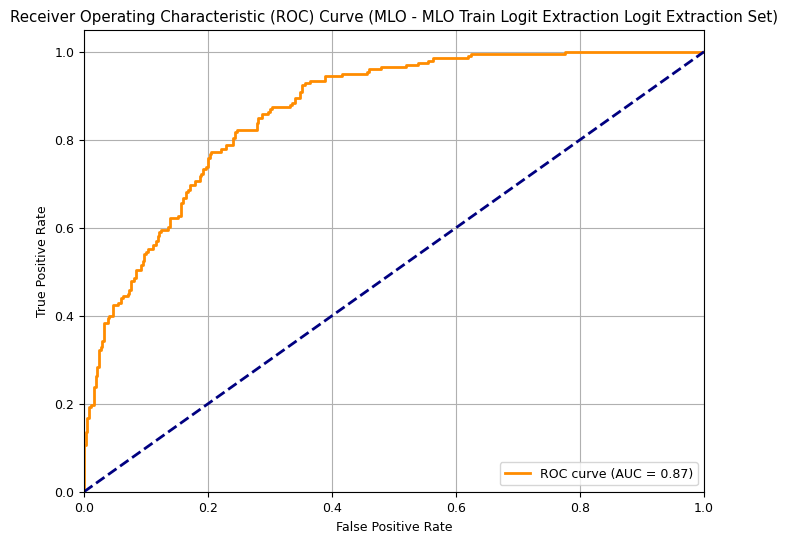


Logistic Regression Model Training Complete.
Logistic Regression Coefficients: [[0.96599928 1.30652062]]
Logistic Regression Intercept: [0.57037015]

--- Evaluating Fusion Model (with pre-trained CNNs) ---

--- Evaluating Full Fusion Model on Validation Set ---
Loaded best trained model for CC from baseline/model_CC_best_val_model.pth
DEBUG : running_corrects 91 and dataset size 122
Final CC Validation Logit Extraction Logit Extraction Loss: 0.5243 Acc: 0.7459


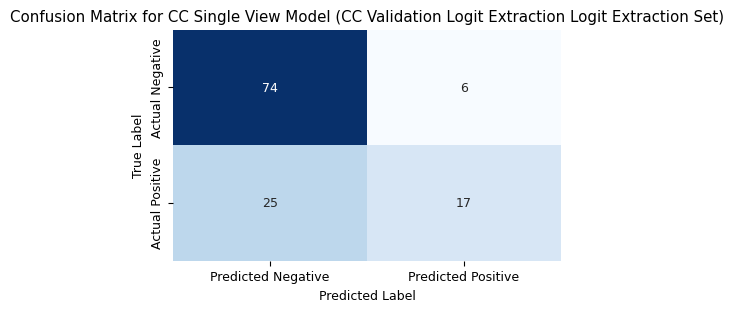

ROC AUC: 0.7824


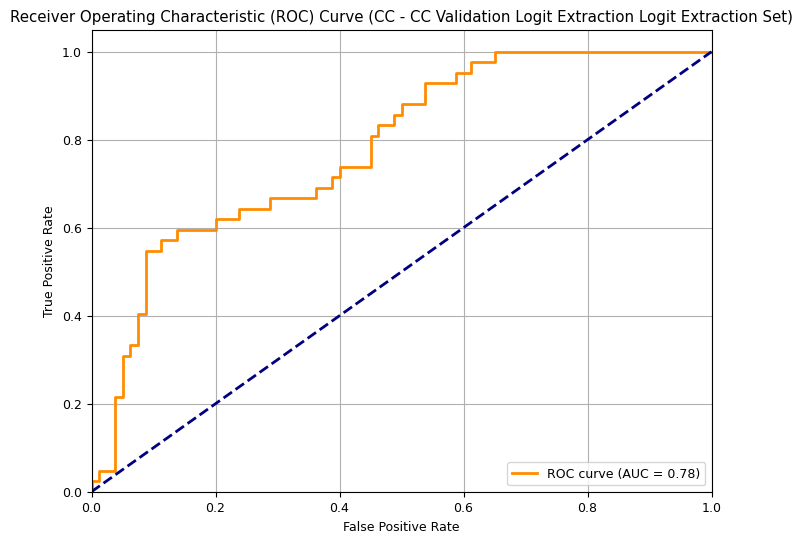

Loaded best trained model for MLO from baseline/model_MLO_best_val_model.pth
DEBUG : running_corrects 90 and dataset size 122
Final MLO Validation Logit Extraction Logit Extraction Loss: 0.5124 Acc: 0.7377


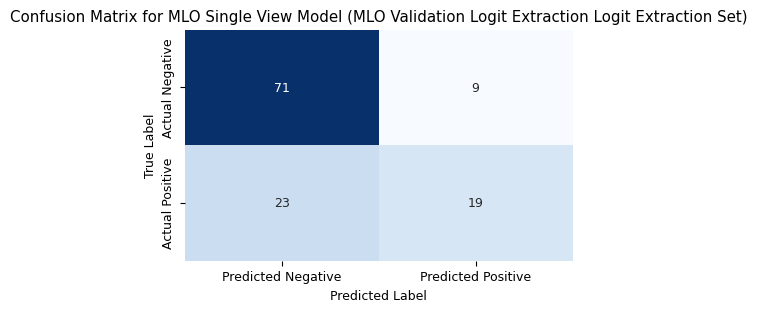

ROC AUC: 0.8179


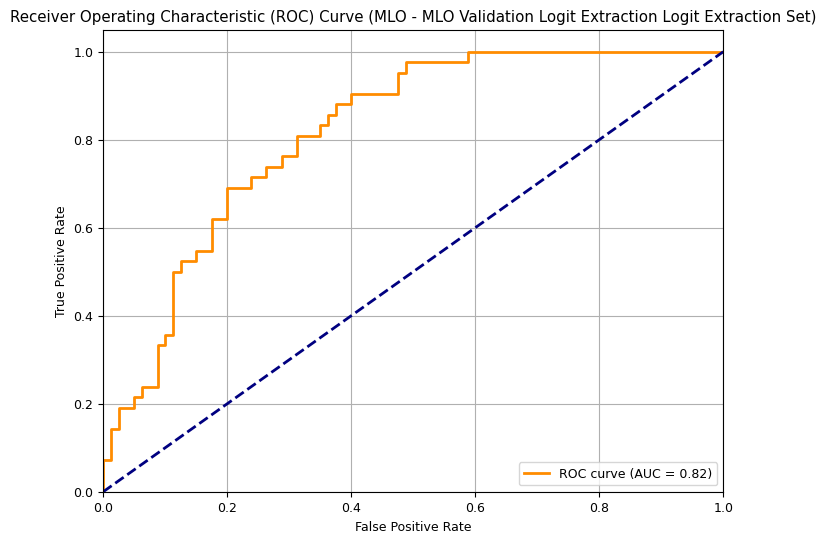

Fusion Model Validation Accuracy: 0.7295
Fusion Model Validation ROC AUC: 0.8494
Fusion Model Validation Confusion Matrix:
[[69 11]
 [22 20]]


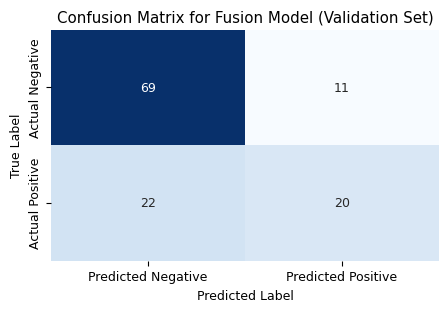

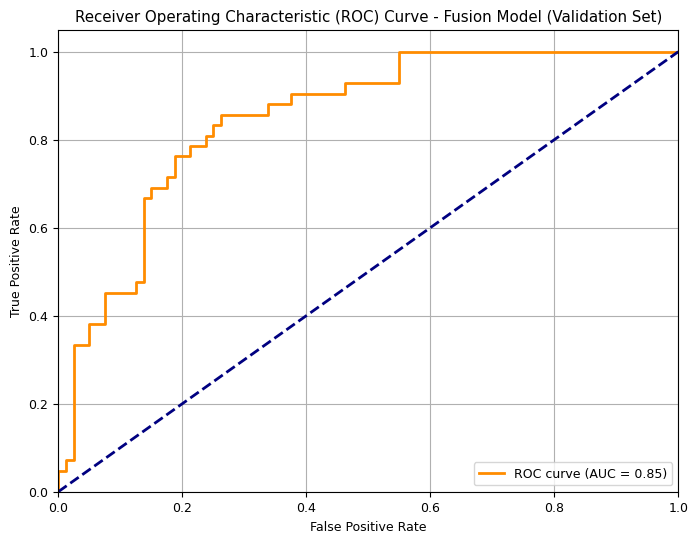


--- Evaluating Full Fusion Model on Test Set ---
Loaded best trained model for CC from baseline/model_CC_best_val_model.pth
DEBUG : running_corrects 95 and dataset size 137
Final CC Test Logit Extraction Logit Extraction Loss: 0.5651 Acc: 0.6934


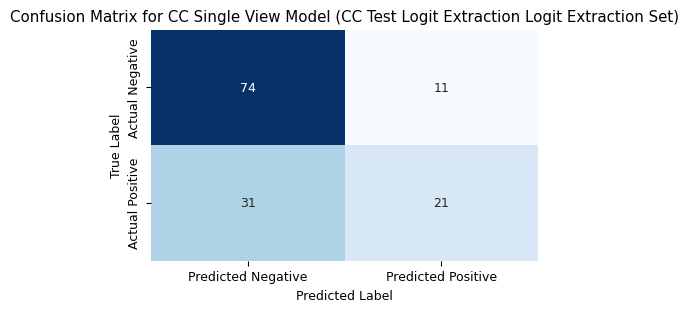

ROC AUC: 0.7495


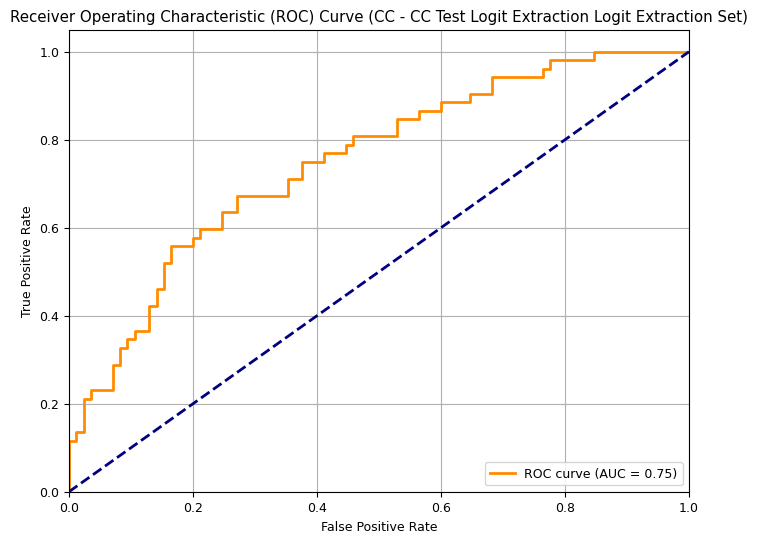

Loaded best trained model for MLO from baseline/model_MLO_best_val_model.pth
DEBUG : running_corrects 93 and dataset size 137
Final MLO Test Logit Extraction Logit Extraction Loss: 0.5644 Acc: 0.6788


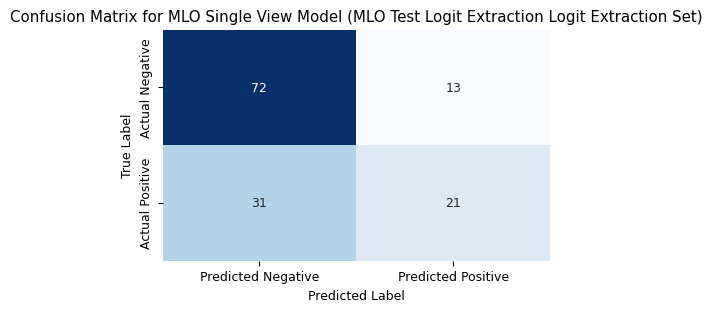

ROC AUC: 0.7489


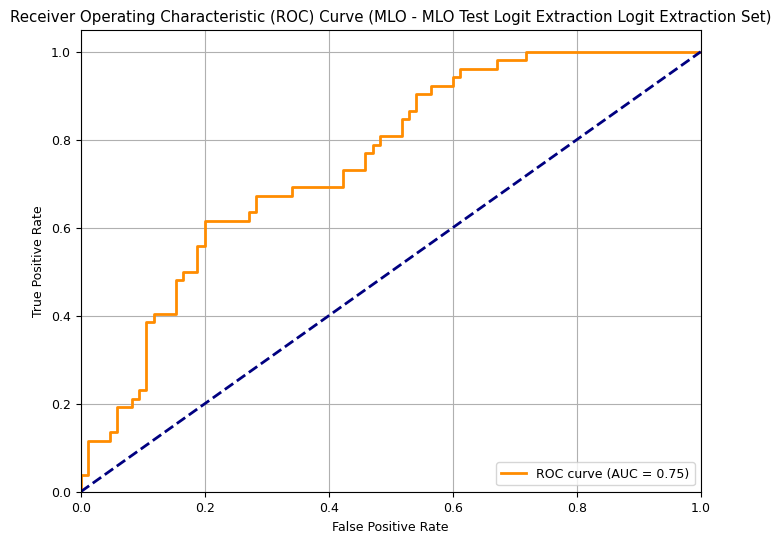

Fusion Model Test Accuracy: 0.7226
Fusion Model Test ROC AUC: 0.7735
Fusion Model Test Confusion Matrix:
[[69 16]
 [22 30]]


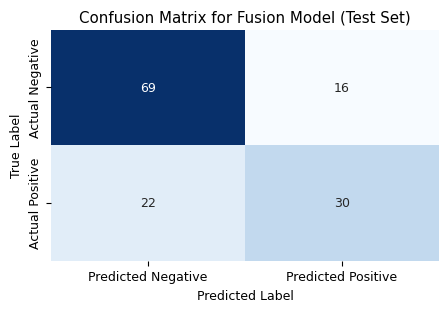

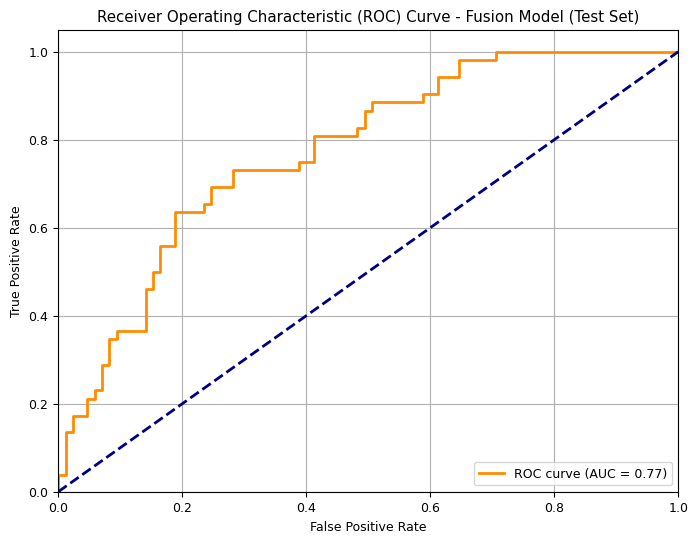

             CC SingleView Test  MLO SingleView Test  Fusion Model Test
Accuracy               0.693431             0.678832           0.722628
Precision              0.656250             0.617647           0.652174
Recall                 0.403846             0.403846           0.576923
Specificity            0.870588             0.847059           0.811765
F1-Score               0.500000             0.488372           0.612245
TP                    21.000000            21.000000          30.000000
FP                    11.000000            13.000000          16.000000
TN                    74.000000            72.000000          69.000000
FN                    31.000000            31.000000          22.000000
AUC                    0.749548             0.748869                NaN

--- Summary of Fusion Model Performance (Pre-trained CNNs) ---
Validation Accuracy: 0.7295, ROC AUC: 0.8494
Test Accuracy: 0.7226, ROC AUC: 0.7735


In [151]:
from late_fusion_lr import LateFusionLR
# Instantiate LateFusionLR with the pre-trained models
print("\n--- Instantiating Fusion Model with pre-trained CNNs ---")

fusion_pipeline_with_trained_cnns = LateFusionLR(
    train_dataset=train_dataset, # Pass original multi-view datasets
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    cc_cnn_model=single_view_cc_cnn,  # Pass the trained CC SingleViewCNN instance
    mlo_cnn_model=single_view_mlo_cnn  # Pass the trained MLO SingleViewCNN instance
)

# Train the fusion pipeline (it will skip the CNN training step)
print("\n--- Training Fusion Pipeline (using pre-trained CNNs) ---")
fusion_pipeline_with_trained_cnns.train_fusion_pipeline()

# Evaluate the fusion model
print("\n--- Evaluating Fusion Model (with pre-trained CNNs) ---")
val_acc, val_roc_auc, val_cm, val_metrics = fusion_pipeline_with_trained_cnns.evaluate_fusion_model("validation")
test_acc, test_roc_auc, test_cm, test_metrics = fusion_pipeline_with_trained_cnns.evaluate_fusion_model("test")

compare_performance_all_views(cc_performance_results, mlo_performance_results, test_metrics)
print("\n--- Summary of Fusion Model Performance (Pre-trained CNNs) ---")
print(f"Validation Accuracy: {val_acc:.4f}, ROC AUC: {val_roc_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, ROC AUC: {test_roc_auc:.4f}")